# Demonstration Notebook

Train a model to recognize notes from input sounds

## Part 1: Data Preparation and Exploration

By Ben Walsh \
For Bnaura

&copy; 2021 Ben Walsh <ben@bnaura.com>

## Contents

1. [Import Libraries](#lib_import)
1. [Data Import](#data_import)
1. [Data Exploration](#data_explore)
1. [Data Augmentation](#data_aug)
1. [Feature Extraction](#feat_extract)
1. [Save Features](#feat_save)


TO DO
- Add column to database for train=1, test=0
- Generalize training functions to look for any files matching corresponding note tag
  - Add _Male2 recordings
- Submodule repo into simple_gui

In [1]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [2]:
import sys
import os
import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import pickle
import sqlite3

from scipy.io import wavfile as wav
from IPython.display import Audio

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import util.music_util as mus 
from util.ml_util import feat_extract, load_training_data
from util import DATA_FOLDER, SCALE


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
../1_audio\hum\Hum_Db4.wav does not exist
../1_audio\hum\Hum_Eb4.wav does not exist
../1_audio\hum\Hum_Gb4.wav does not exist
../1_audio\hum\Hum_Ab4.wav does not exist
../1_audio\hum\Hum_Bb4.wav does not exist
../1_audio\hum\Hum_B4.wav does not exist


## <a id = "data_import"></a>2. Data Import

In [3]:
X, y, fs = load_training_data(SCALE)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:124: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [4]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(SCALE)))
print('X sample length is {}'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(SCALE)))

X is a <class 'numpy.ndarray'> with shape (6, 120000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 120000
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

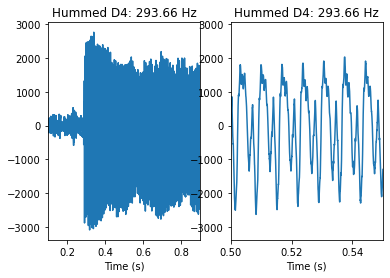

In [5]:
# Pick a note to plot
idx_test = 1
signal_test = X[idx_test,:]
note_test = SCALE[idx_test]

# Create array of time samples, converting number of samples and dividing by sample of frequency 
t_array = np.arange(X.shape[1])/fs

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test)

# Plot waveform over shorter time period to see sine
plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test)

plt.show()


### Plot Frequency

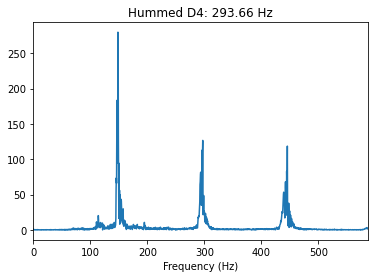

In [6]:
# Take FFT
ftransform = np.fft.fft(signal_test)/len(signal_test)
ftransform = ftransform[range(int(len(signal_test)/2))]
tp_count = len(signal_test)
vals = np.arange(tp_count/2)
t_period = tp_count/fs

# Scale to Hz frequency values for plotting
freqs = vals/t_period

plt.plot(freqs, abs(ftransform))
plt.xlim((0, 2*mus.note_to_freq[note_test]))
plt.xlabel('Frequency (Hz)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.show()

## <a id = "data_aug"></a> 4. Data Augmentation 

Synthesize dataset `aug_factor` times larger

In [7]:
aug_factor = 20

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((aug_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((aug_factor*X.shape[0], 1)), columns=['note'])

### 4.1 Add time shifts

Demonstrate time shift code

In [8]:
arr1 = np.array(np.arange(1,6))
print(arr1)
print(mus.add_timeshifts(arr1, samp_shift_max=4, debug=True))

[1 2 3 4 5]
Shape of input array = (5,)
Input samp_shift_max = 4
Random prepad_len = 2
[0. 0. 1. 2. 3.]


Apply time shifts to augmented training data

In [9]:
# Add random time shifts noise to each element
T_SHIFT_MAX = 0.1 # seconds
DEBUG=False

#X_aug = X_aug.apply(lambda x: mus.add_timeshifts(x, 
#                                         samp_shift_max=np.int(T_SHIFT_MAX*fs), 
#                                         debug=DEBUG), axis=1) 

for idx in range(X.shape[0]):
            
    # Initialize truth values in synthesized set
    y_aug.loc[aug_factor*idx:aug_factor*(idx+1)]=SCALE[idx]
    
    for sample in range(aug_factor):
        X_aug[sample+aug_factor*idx,:] = mus.add_timeshifts(X[idx,:], samp_shift_max=np.int(T_SHIFT_MAX*fs), debug=DEBUG)        

### 4.2 Add noise 
Add noise to original recordings

In [10]:
NOISE_AMPL = 100

# Add white noise to each element
X_aug = pd.DataFrame(X_aug).apply(lambda x: mus.add_noise(x, 
                                    ampl=NOISE_AMPL),
                                    axis=1).values

Sanity check the dimensions of the augmented training set

In [11]:
print('X_aug has shape {}, with aug_factor = {}'.format(X_aug.shape, aug_factor))
print('Original X has shape {}'.format(X.shape))
print('y_aug has shape {}'.format(y_aug.shape))

X_aug has shape (120, 120000), with aug_factor = 20
Original X has shape (6, 120000)
y_aug has shape (120, 1)


### Plot example with added noise and shifts

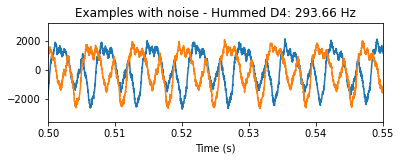

In [12]:
idx_test = 1
signal_test1 = X_aug[idx_test*aug_factor,:]
signal_test2 = X_aug[idx_test*aug_factor+5,:]
note_test = SCALE[idx_test]

# Plot waveform over shorter time period to see sine
plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Examples with noise - Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test1)
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [13]:
X_feat = feat_extract(X_aug, fs, mus.note_to_freq, SCALE, debug=True)

Feature extraction processing time = 3.327


In [14]:
X_feat.head()

,mfcc_logfbank_0,mfcc_logfbank_1,mfcc_logfbank_2,mfcc_logfbank_3,mfcc_logfbank_4,mfcc_logfbank_5,mfcc_logfbank_6,mfcc_logfbank_7,mfcc_logfbank_8,mfcc_logfbank_9,...,mfcc_logfbank_16,mfcc_logfbank_17,mfcc_logfbank_18,mfcc_logfbank_19,mfcc_logfbank_20,mfcc_logfbank_21,mfcc_logfbank_22,mfcc_logfbank_23,mfcc_logfbank_24,mfcc_logfbank_25
0,2938.199537,2943.730696,2809.493946,2624.981515,2099.030806,2013.731479,1997.332035,2464.187363,2544.541841,2337.502723,...,2946.795635,3045.433179,3120.888301,3217.740550,3311.978644,3396.519525,3476.399126,3549.691325,3623.684894,3683.956423
1,2918.225163,2922.715258,2789.812730,2606.786861,2101.414283,2002.636910,1992.135812,2460.331774,2533.845339,2319.596758,...,2948.016559,3044.989808,3127.052194,3207.157647,3303.154816,3389.114515,3474.106951,3555.623256,3625.027914,3683.588236
2,2914.042883,2921.073435,2788.947691,2611.179751,2110.418770,2021.996563,1991.129935,2453.241292,2529.598410,2314.828572,...,2943.151607,3029.295157,3110.763770,3210.404403,3308.295399,3391.621734,3479.984721,3555.952623,3621.957176,3682.905741
3,2913.671934,2921.533711,2790.688731,2605.699296,2094.987458,2010.757751,1991.564883,2452.425462,2530.796788,2321.782415,...,2936.505252,3039.474618,3126.899465,3221.955021,3306.407304,3394.897340,3481.946471,3558.151541,3626.743552,3681.865668
4,2878.822670,2893.014590,2767.677560,2587.756628,2090.426724,2009.169250,1987.839071,2445.370827,2533.785224,2327.763032,...,2949.108197,3042.144689,3128.576401,3214.779463,3303.275587,3392.253368,3474.694294,3558.883957,3624.535078,3678.867606


### Explore extracted features

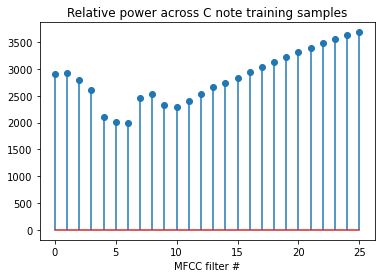

In [15]:
NOTE_TEST = 'C'
plt.stem(X_feat[y_aug['note'].str.contains(NOTE_TEST)].mean())
#plt.bar(SCALE, X_feat[y_aug['note'].str.contains(NOTE_TEST)].mean())
plt.title('Relative power across {} note training samples'.format(NOTE_TEST))
plt.xlabel('MFCC filter #')
plt.show()

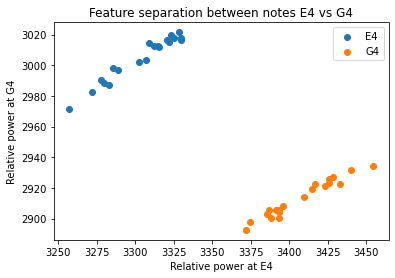

In [16]:
NOTE1 = 'E4'
NOTE2 = 'G4'
#plt.scatter(X_feat[y_aug['note'].str.contains(NOTE1)][NOTE1], 
#            X_feat[y_aug['note'].str.contains(NOTE1)][NOTE2])
#plt.scatter(X_feat[y_aug['note'].str.contains(NOTE2)][NOTE1], 
#            X_feat[y_aug['note'].str.contains(NOTE2)][NOTE2])

feat1 = 'mfcc_logfbank_1'
feat2 = 'mfcc_logfbank_2'

plt.scatter(X_feat[y_aug['note'].str.contains(NOTE1)][feat1], 
            X_feat[y_aug['note'].str.contains(NOTE1)][feat2])
plt.scatter(X_feat[y_aug['note'].str.contains(NOTE2)][feat1], 
            X_feat[y_aug['note'].str.contains(NOTE2)][feat2])

plt.ylabel('Relative power at {}'.format(NOTE2))
plt.xlabel('Relative power at {}'.format(NOTE1))
plt.legend([NOTE1, NOTE2])
plt.title('Feature separation between notes {} vs {}'.format(NOTE1, NOTE2))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

### Using SQL

In [17]:
FEAT_DB_NAME = os.path.join(DATA_FOLDER, 'features.db')
TABLE_NAME = 'X_all'
conn = sqlite3.connect(FEAT_DB_NAME)
c = conn.cursor()

# Create table
c.execute('''CREATE TABLE IF NOT EXISTS {}
             ({} real, {} real, {} real, 
             {} real, {} real, {} real)'''.format(TABLE_NAME, X_feat.columns[0],
                                                    X_feat.columns[1],
                                                 X_feat.columns[2],
                                                 X_feat.columns[3],
                                                 X_feat.columns[4],
                                                 X_feat.columns[5]))

# Commit the changes to db
conn.commit()

# Insert multiple records in a single query
c.executemany('INSERT INTO {} VALUES(?,?,?,?,?,?);'.format(TABLE_NAME), X_feat.values);
conn.commit()

# Close the connection
conn.close()

ProgrammingError: Incorrect number of bindings supplied. The current statement uses 6, and there are 26 supplied.

### Using CSV

Split data for training and testing and save off features

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)

if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)

X_train.to_csv(os.path.join(DATA_FOLDER, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(DATA_FOLDER, 'X_test.csv'), index=False)

y_train.to_csv(os.path.join(DATA_FOLDER, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(DATA_FOLDER, 'y_test.csv'), index=False)